# Build first simple Tensorflow model

In this demo notebook we will be going through the following steps when building our first Tensorflow model
- Define the input features
- Define an input function
- Setup evaluation metric
- Create a linear regressor
- Run experiment
- Evaluate the model

In [1]:
import tensorflow as tf
import pandas as pd
import shutil
print(tf.__version__)

1.2.1


In [11]:
#First stup a train, validation and test data set
train_data_file = '/content/datalab/data/train-data.csv'
valid_data_file = '/content/datalab/data/valid-data.csv'
test_data_file = '/content/datalab/data/test-data.csv'

# Define Dataset Metadata

In this part what we do:
- Setup our metadata features for input
- Setup metadata features for target

In [13]:
#Define header names
HEADER = ['pickup_datetime',
          'pickup_dayofweek',
          'pickup_hour',
          'pickup_longitude',
          'pickup_latitude',
          'dropoff_longitude',
          'dropoff_latitude', 
          'passenger_count',
          'fare_amount']

#Setup default values for missing
DEFAULTS = [['NULL'],['NULL'],[-1], [-74.0], [40.0], [-74.0], [40.7], [-1],[-.1]]

NUMERIC_FEATURE_NAMES = ['pickup_longitude', 
                         'pickup_latitude',
                         'dropoff_longitude', 
                         'dropoff_latitude', 
                         'passenger_count']

CATEGORICAL_FEATURE_NAMES = []

#Variable with all the feature names
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

#Set Target
TARGET_NAME = 'fare_amount'

#Unused features
UNUSED_FEATURE_NAMES = set(HEADER) - set(FEATURE_NAMES) - set([TARGET_NAME])

#Print features + unused features
print("Numeric features: {}".format(NUMERIC_FEATURE_NAMES))
print("Categorical features: {}".format(CATEGORICAL_FEATURE_NAMES))
print("Target: {}".format(TARGET_NAME))
print("Unused features: {}".format(UNUSED_FEATURE_NAMES))

Numeric features: ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
Categorical features: []
Target: fare_amount
Unused features: set(['pickup_dayofweek', 'pickup_hour', 'pickup_datetime'])


# Define input features

In this part what we do:
- We use tf.feature_column.numeric_column to setup our feature columns 
- TF.feature_column is used for ingesting and representing features 
- Find more information: [here](https://www.tensorflow.org/api_docs/python/tf/feature_column)

In [14]:
#Create the input features using a tf.feature_column.numeric_column
def create_feature_columns():

    numeric_columns = list(map(lambda feature_name: tf.feature_column.numeric_column(feature_name, dtype=tf.float32),
                               NUMERIC_FEATURE_NAMES))

    feature_columns = numeric_columns
    
    return feature_columns

# Test create_feature_columns()
feature_columns = create_feature_columns() 
print(feature_columns)

[_NumericColumn(key='pickup_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='pickup_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='dropoff_longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='dropoff_latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='passenger_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


# Define a data input function

In this part what we do:
- Seting up an input function that will feed our data in to the model 
- We can feed a pandas dataframe in to our TF Estimator
- Test if the pandas_input_fn works

In [15]:
#Setup input function
def pandas_input_fn(data_frame):
  
  
    continuous_features = {f: tf.constant(data_frame[f].values, dtype=tf.float32) for f in NUMERIC_FEATURE_NAMES}

    features = continuous_features
 
    target = tf.constant(data_frame[TARGET_NAME].values, dtype=tf.float32)

    return features, target
  
# Test pandas_input_fn()
df_train = pd.read_csv(train_data_file, header=None, names=HEADER)
features,target = pandas_input_fn(df_train)
feature_colum_names = list(features.keys())
print(feature_colum_names)
print(target)

['dropoff_longitude', 'passenger_count', 'pickup_latitude', 'dropoff_latitude', 'pickup_longitude']
Tensor("Const_5:0", shape=(8000,), dtype=float32)


#  Define the evaluation metric

In this part we do:
- Setup RMSE as our evaluation metric using [tf.contrib.learn.MetricSpec](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/MetricSpec)
- Make sure we do that for our train, validate and test set

In [16]:
#setup our evaluation metric
evaluation_metrics={
    'rmse': tf.contrib.learn.MetricSpec(metric_fn=tf.metrics.root_mean_squared_error)
    }

def print_evaluation(estimator):
    
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    train_metric = estimator.evaluate(input_fn = lambda: pandas_input_fn(df_train), 
                                        steps=1, 
                                        metrics = evaluation_metrics)

    valid_metric = estimator.evaluate(input_fn = lambda: pandas_input_fn(df_valid), 
                                        steps=1, 
                                        metrics = evaluation_metrics)

    test_metric = estimator.evaluate(input_fn = lambda: pandas_input_fn(df_test), 
                                       steps=1, 
                                       metrics = evaluation_metrics)

    print("")
    print("train metric:{}".format(train_metric))
    print("valid metric:{}".format(valid_metric))
    print("test metric:{}".format(test_metric))

# Create a Linear Regression Estimator

Now we're getting to the actual modelling part! Here we're:
  - Initializing our tf.estimator model (Linear Regressor)
  - Set our optimizer (Gradient Descent)
  - Create experiment and run it

In [17]:
#Setup our experiment using a linear regressor. 
def experiment_linear_regression(run_config,hparams):
   #We use a Gradient Descent Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = hparams.learning_rate)
  
    estimator = tf.contrib.learn.LinearRegressor(
        feature_columns=feature_columns,
        optimizer = optimizer,
        config=run_config)
      
    experiment =  tf.contrib.learn.Experiment(estimator=estimator, 
                                   train_steps = hparams.training_steps,
                                   train_input_fn = lambda: pandas_input_fn(df_train), 
                                   eval_input_fn =lambda: pandas_input_fn(df_valid),
                                   eval_metrics = evaluation_metrics
                                  )
    return experiment

# Set params and run Linear Regression

Now we can run our model! We need to do a few things here
- Create Pandas data frames for train validation and test
- Define our hyperparamaters
- Clear our model directory
- Set loggin
- Run our experiment

In [19]:

# Load dataset into dataframes
df_train = pd.read_csv('/content/datalab/data/train-data.csv', header=None, names=HEADER)
df_valid = pd.read_csv('/content/datalab/data/valid-data.csv', header=None, names=HEADER)
df_test = pd.read_csv('/content/datalab/data/test-data.csv', header=None, names=HEADER)

# Define algorithm and experiment parameters
hparams  = tf.contrib.training.HParams(training_steps=10000, learning_rate=0.00001)

# Set trained model location
model_dir = "trained_models/linear_regression_model"

# Clear model directory
shutil.rmtree(model_dir, ignore_errors=True)

run_config = tf.contrib.learn.RunConfig(
    model_dir=model_dir
)

# Run experiement
tf.logging.set_verbosity(tf.logging.INFO)
tf.contrib.learn.learn_runner.run(experiment_fn = experiment_linear_regression, 
                               run_config = run_config,
                               schedule="train_and_evaluate",
                               hparams=hparams)

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/linear_regression_model', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cdfe792d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_session_config': None}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of ta

({'global_step': 10000, 'loss': 128.6485, 'rmse': 11.34234}, [])

# Evaluate the trained Model - Linear Regression¶

Now it's time to evaluate our Linear Regressor. 

In [20]:
linear_model = tf.contrib.learn.LinearRegressor(
        feature_columns=feature_columns,
        config=run_config)

print_evaluation(linear_model)

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/linear_regression_model', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2cdfe792d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_session_config': None}

train metric:{'loss': 119.26549, 'global_step': 10000, 'rmse': 10.920874}
valid metric:{'loss': 128.64859, 'global_step': 10000, 'rmse': 11.342337}
test metric:{'loss': 128.56544, 'global_step': 10000, 'rmse': 11.338671}


# Create another experiment usting Deep Neural Network (DNN)

So we have trained our first model. Now we can try a different one - Deep Neural Network. Here we're going to:
- Setup another experiment
- Initialize a deep neural network estimator
- Run the experiment

In [21]:
#Setup experiment, initialize estimator and run experiment. 
def experiment_dnn_regression(run_config,hparams):
    
    dnn_estimator = tf.contrib.learn.DNNRegressor(
            feature_columns = feature_columns,
            hidden_units=hparams.hidden_units,
            config = run_config
    )
    
    experiment =  tf.contrib.learn.Experiment(estimator = dnn_estimator, 
                                     train_steps = hparams.training_steps,
                                     train_input_fn = lambda: pandas_input_fn(df_train),
                                     eval_input_fn =lambda: pandas_input_fn(df_valid),
                                     eval_metrics = evaluation_metrics
                                    )
    return experiment

# Set params and run experiemnt - DNN

Now we can run our model! We need to do a few things here
- Create Pandas data frames for train validation and test
- Define our hyperparamaters
- Clear our model directory
- Set loggin
- Run our experiment

In [22]:
# Load dataset into dataframes
df_train = pd.read_csv('/content/datalab/data/train-data.csv', header=None, names=HEADER)
df_valid = pd.read_csv('/content/datalab/data/valid-data.csv', header=None, names=HEADER)
df_test = pd.read_csv('/content/datalab/data/test-data.csv', header=None, names=HEADER)

# Set params
hparams  = tf.contrib.training.HParams(training_steps=1000,
                                       hidden_units=[32, 8, 2])
model_dir = "trained_models/dnn_regression_model"

# Clear model directory# Clear model directory
shutil.rmtree(model_dir, ignore_errors=True)

run_config = tf.contrib.learn.RunConfig(
    model_dir=model_dir
)

# Run the experiment
tf.logging.set_verbosity(tf.logging.WARN)
tf.contrib.learn.learn_runner.run(experiment_fn = experiment_dnn_regression, 
                               run_config = run_config,
                               schedule="train_and_evaluate",
                               hparams=hparams)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passi

({'global_step': 1000, 'loss': 230.79692, 'rmse': 15.192014}, [])

# Evaluate the trained model - DNN

Now it's time to evaluate our Deep Neural Network. 

In [23]:
dnn_model = tf.contrib.learn.DNNRegressor(
            feature_columns = feature_columns,
            hidden_units=hparams.hidden_units,
            config = run_config
    )

print_evaluation(dnn_model)


train metric:{'loss': 215.55832, 'global_step': 1000, 'rmse': 14.681905}
valid metric:{'loss': 230.79709, 'global_step': 1000, 'rmse': 15.192007}
test metric:{'loss': 228.33098, 'global_step': 1000, 'rmse': 15.110624}


# Results so far

Now we are plotting our results so far. 

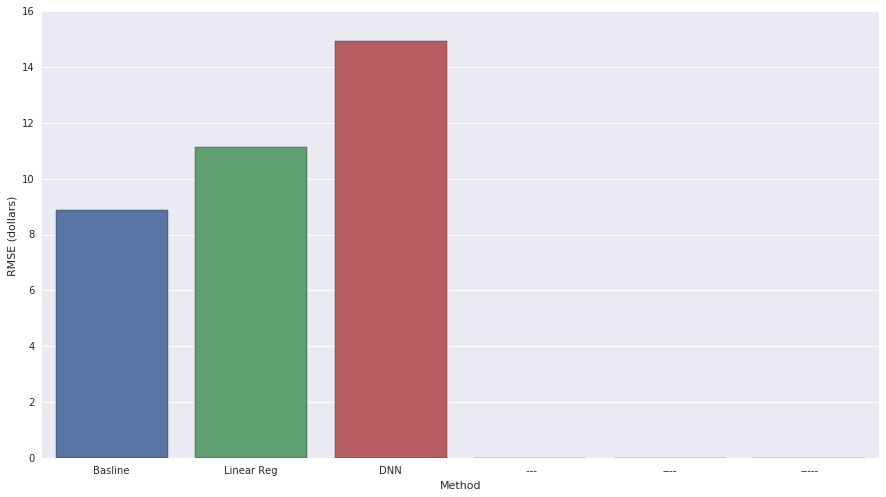

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({
              'Method' : pd.Series(['Basline', 'Linear Reg', 'DNN', ' ---', '----', '-----']),
              'RMSE': pd.Series([8.89, 11.15, 14.94, 0, 0, 0.0]) })

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df, x='Method', y='RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Method')